In [1]:
import pandas as pd
from loaders.Loaders import CSVLoader
from compoundFeaturization.rdkitFingerprints import MorganFingerprint, MACCSkeysFingerprint
from splitters.splitters import SingletaskStratifiedSplitter
from featureSelection.baseFeatureSelector import LowVarianceFS
import numpy as np

In [2]:
#Load Dataset
dataset = CSVLoader(dataset_path='preprocessed_dataset_wfoodb.csv', 
                    mols_field='Smiles', 
                    labels_fields='Class', 
                    id_field='ID')#, shard_size=4000)
dataset = dataset.create_dataset()
dataset.get_shape()

Mols_shape:  23290
Features_shape:  X not defined!
Labels_shape:  (23290,)


In [3]:
#Separate sweeteners from non sweeteners
sweets_indexes = np.where(dataset.y == 1)
test_sweets_indexes = sweets_indexes[0][:130]
sweets_indexes = sweets_indexes[0][130:]

sweets = dataset.select(sweets_indexes)
sweets_test = dataset.select(test_sweets_indexes)

non_sweets_indexes = np.where(dataset.y == 0)
test_non_sweets_indexes = non_sweets_indexes[0][:130]
non_sweets_indexes = non_sweets_indexes[0][130:]

non_sweets = dataset.select(non_sweets_indexes)
non_sweets_test = dataset.select(test_non_sweets_indexes)

#Ratio between sweeteners and non sweeteners
n_balanced_datasets = int(np.floor(len(non_sweets.y)/len(sweets.y)))
n_balanced_datasets

indexes = list(range(0, len(non_sweets.y)))

import random
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

dataset_indexes = partition(indexes, n_balanced_datasets)


balanced_datasets = []
for i, di in enumerate(dataset_indexes):
    ds = non_sweets.select(di)
    ds = ds.merge([sweets])
    balanced_datasets.append(ds)
    
test_bl_dataset = sweets_test.merge([non_sweets_test])

In [4]:
#Featurization
dataset = MACCSkeysFingerprint().featurize(balanced_datasets[0])
#dataset = MorganFingerprint().featurize(dataset)
dataset.get_shape()

#Feature Selection
#dataset = LowVarianceFS(0.15).featureSelection(dataset)
#dataset.get_shape()

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Mols_shape:  2406
Features_shape:  (2406, 167)
Labels_shape:  (2406,)


In [5]:
smartsPatts = {
  1: ('?', 0),  # ISOTOPE
  2:('[#104,#105,#106,#107,#106,#109,#110,#111,#112]',0),  # atomic num >103 Not complete
  2: ('[#104]', 0),  # limit the above def'n since the RDKit only accepts up to #104
  3: ('[#32,#33,#34,#50,#51,#52,#82,#83,#84]', 0),  # Group IVa,Va,VIa Rows 4-6 
  4: ('[Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr]', 0),  # actinide
  5: ('[Sc,Ti,Y,Zr,Hf]', 0),  # Group IIIB,IVB (Sc...)  
  6: ('[La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu]', 0),  # Lanthanide
  7: ('[V,Cr,Mn,Nb,Mo,Tc,Ta,W,Re]', 0),  # Group VB,VIB,VIIB
  8: ('[!#6;!#1]1~*~*~*~1', 0),  # QAAA@1
  9: ('[Fe,Co,Ni,Ru,Rh,Pd,Os,Ir,Pt]', 0),  # Group VIII (Fe...)
  10: ('[Be,Mg,Ca,Sr,Ba,Ra]', 0),  # Group IIa (Alkaline earth)
  11: ('*1~*~*~*~1', 0),  # 4M Ring
  12: ('[Cu,Zn,Ag,Cd,Au,Hg]', 0),  # Group IB,IIB (Cu..)
  13: ('[#8]~[#7](~[#6])~[#6]', 0),  # ON(C)C
  14: ('[#16]-[#16]', 0),  # S-S
  15: ('[#8]~[#6](~[#8])~[#8]', 0),  # OC(O)O
  16: ('[!#6;!#1]1~*~*~1', 0),  # QAA@1
  17: ('[#6]#[#6]', 0),  #CTC
  18: ('[#5,#13,#31,#49,#81]', 0),  # Group IIIA (B...) 
  19: ('*1~*~*~*~*~*~*~1', 0),  # 7M Ring
  20: ('[#14]', 0),  #Si
  21: ('[#6]=[#6](~[!#6;!#1])~[!#6;!#1]', 0),  # C=C(Q)Q
  22: ('*1~*~*~1', 0),  # 3M Ring
  23: ('[#7]~[#6](~[#8])~[#8]', 0),  # NC(O)O
  24: ('[#7]-[#8]', 0),  # N-O
  25: ('[#7]~[#6](~[#7])~[#7]', 0),  # NC(N)N
  26: ('[#6]=;@[#6](@*)@*', 0),  # C$=C($A)$A
  27: ('[I]', 0),  # I
  28: ('[!#6;!#1]~[CH2]~[!#6;!#1]', 0),  # QCH2Q
  29: ('[#15]', 0),  # P
  30: ('[#6]~[!#6;!#1](~[#6])(~[#6])~*', 0),  # CQ(C)(C)A
  31: ('[!#6;!#1]~[F,Cl,Br,I]', 0),  # QX
  32: ('[#6]~[#16]~[#7]', 0),  # CSN
  33: ('[#7]~[#16]', 0),  # NS
  34: ('[CH2]=*', 0),  # CH2=A
  35: ('[Li,Na,K,Rb,Cs,Fr]', 0),  # Group IA (Alkali Metal)
  36: ('[#16R]', 0),  # S Heterocycle
  37: ('[#7]~[#6](~[#8])~[#7]', 0),  # NC(O)N
  38: ('[#7]~[#6](~[#6])~[#7]', 0),  # NC(C)N
  39: ('[#8]~[#16](~[#8])~[#8]', 0),  # OS(O)O
  40: ('[#16]-[#8]', 0),  # S-O
  41: ('[#6]#[#7]', 0),  # CTN
  42: ('F', 0),  # F
  43: ('[!#6;!#1;!H0]~*~[!#6;!#1;!H0]', 0),  # QHAQH
  44: ('[!#1;!#6;!#7;!#8;!#9;!#14;!#15;!#16;!#17;!#35;!#53]', 0),  # OTHER
  45: ('[#6]=[#6]~[#7]', 0),  # C=CN
  46: ('Br', 0),  # BR
  47: ('[#16]~*~[#7]', 0),  # SAN
  48: ('[#8]~[!#6;!#1](~[#8])(~[#8])', 0),  # OQ(O)O
  49: ('[!+0]', 0),  # CHARGE  
  50: ('[#6]=[#6](~[#6])~[#6]', 0),  # C=C(C)C
  51: ('[#6]~[#16]~[#8]', 0),  # CSO
  52: ('[#7]~[#7]', 0),  # NN
  53: ('[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]', 0),  # QHAAAQH
  54: ('[!#6;!#1;!H0]~*~*~[!#6;!#1;!H0]', 0),  # QHAAQH
  55: ('[#8]~[#16]~[#8]', 0),  #OSO
  56: ('[#8]~[#7](~[#8])~[#6]', 0),  # ON(O)C
  57: ('[#8R]', 0),  # O Heterocycle
  58: ('[!#6;!#1]~[#16]~[!#6;!#1]', 0),  # QSQ
  59: ('[#16]!:*:*', 0),  # Snot%A%A
  60: ('[#16]=[#8]', 0),  # S=O
  61: ('*~[#16](~*)~*', 0),  # AS(A)A
  62: ('*@*!@*@*', 0),  # A$!A$A
  63: ('[#7]=[#8]', 0),  # N=O
  64: ('*@*!@[#16]', 0),  # A$A!S
  65: ('c:n', 0),  # C%N
  66: ('[#6]~[#6](~[#6])(~[#6])~*', 0),  # CC(C)(C)A
  67: ('[!#6;!#1]~[#16]', 0),  # QS
  68: ('[!#6;!#1;!H0]~[!#6;!#1;!H0]', 0),  # QHQH (&...) SPEC Incomplete
  69: ('[!#6;!#1]~[!#6;!#1;!H0]', 0),  # QQH
  70: ('[!#6;!#1]~[#7]~[!#6;!#1]', 0),  # QNQ
  71: ('[#7]~[#8]', 0),  # NO
  72: ('[#8]~*~*~[#8]', 0),  # OAAO
  73: ('[#16]=*', 0),  # S=A
  74: ('[CH3]~*~[CH3]', 0),  # CH3ACH3
  75: ('*!@[#7]@*', 0),  # A!N$A
  76: ('[#6]=[#6](~*)~*', 0),  # C=C(A)A
  77: ('[#7]~*~[#7]', 0),  # NAN
  78: ('[#6]=[#7]', 0),  # C=N
  79: ('[#7]~*~*~[#7]', 0),  # NAAN
  80: ('[#7]~*~*~*~[#7]', 0),  # NAAAN
  81: ('[#16]~*(~*)~*', 0),  # SA(A)A
  82: ('*~[CH2]~[!#6;!#1;!H0]', 0),  # ACH2QH
  83: ('[!#6;!#1]1~*~*~*~*~1', 0),  # QAAAA@1
  84: ('[NH2]', 0),  #NH2
  85: ('[#6]~[#7](~[#6])~[#6]', 0),  # CN(C)C
  86: ('[C;H2,H3][!#6;!#1][C;H2,H3]', 0),  # CH2QCH2
  87: ('[F,Cl,Br,I]!@*@*', 0),  # X!A$A
  88: ('[#16]', 0),  # S
  89: ('[#8]~*~*~*~[#8]', 0),  # OAAAO
  90:
  ('[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[CH2;R]1)]',
   0),  # QHAACH2A
  91:
  ('[$([!#6;!#1;!H0]~*~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~*~[R]1@[R]@[CH2;R]1)]',
   0),  # QHAAACH2A
  92: ('[#8]~[#6](~[#7])~[#6]', 0),  # OC(N)C
  93: ('[!#6;!#1]~[CH3]', 0),  # QCH3
  94: ('[!#6;!#1]~[#7]', 0),  # QN
  95: ('[#7]~*~*~[#8]', 0),  # NAAO
  96: ('*1~*~*~*~*~1', 0),  # 5 M ring
  97: ('[#7]~*~*~*~[#8]', 0),  # NAAAO
  98: ('[!#6;!#1]1~*~*~*~*~*~1', 0),  # QAAAAA@1
  99: ('[#6]=[#6]', 0),  # C=C
  100: ('*~[CH2]~[#7]', 0),  # ACH2N
  101:
  ('[$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1)]',
   0),  # 8M Ring or larger. This only handles up to ring sizes of 14
  102: ('[!#6;!#1]~[#8]', 0),  # QO
  103: ('Cl', 0),  # CL
  104: ('[!#6;!#1;!H0]~*~[CH2]~*', 0),  # QHACH2A
  105: ('*@*(@*)@*', 0),  # A$A($A)$A
  106: ('[!#6;!#1]~*(~[!#6;!#1])~[!#6;!#1]', 0),  # QA(Q)Q
  107: ('[F,Cl,Br,I]~*(~*)~*', 0),  # XA(A)A
  108: ('[CH3]~*~*~*~[CH2]~*', 0),  # CH3AAACH2A
  109: ('*~[CH2]~[#8]', 0),  # ACH2O
  110: ('[#7]~[#6]~[#8]', 0),  # NCO
  111: ('[#7]~*~[CH2]~*', 0),  # NACH2A
  112: ('*~*(~*)(~*)~*', 0),  # AA(A)(A)A
  113: ('[#8]!:*:*', 0),  # Onot%A%A
  114: ('[CH3]~[CH2]~*', 0),  # CH3CH2A
  115: ('[CH3]~*~[CH2]~*', 0),  # CH3ACH2A
  116: ('[$([CH3]~*~*~[CH2]~*),$([CH3]~*1~*~[CH2]1)]', 0),  # CH3AACH2A
  117: ('[#7]~*~[#8]', 0),  # NAO
  118: ('[$(*~[CH2]~[CH2]~*),$(*1~[CH2]~[CH2]1)]', 1),  # ACH2CH2A > 1
  119: ('[#7]=*', 0),  # N=A
  120: ('[!#6;R]', 1),  # Heterocyclic atom > 1 (&...) Spec Incomplete
  121: ('[#7;R]', 0),  # N Heterocycle
  122: ('*~[#7](~*)~*', 0),  # AN(A)A
  123: ('[#8]~[#6]~[#8]', 0),  # OCO
  124: ('[!#6;!#1]~[!#6;!#1]', 0),  # QQ
  125: ('?', 0),  # Aromatic Ring > 1
  126: ('*!@[#8]!@*', 0),  # A!O!A
  127: ('*@*!@[#8]', 1),  # A$A!O > 1 (&...) Spec Incomplete
  128:
  ('[$(*~[CH2]~*~*~*~[CH2]~*),$([R]1@[CH2;R]@[R]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[R]@[CH2;R]1),$(*~[CH2]~*~[R]1@[R]@[CH2;R]1)]',
   0),  # ACH2AAACH2A
  129: ('[$(*~[CH2]~*~*~[CH2]~*),$([R]1@[CH2]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[CH2;R]1)]',
        0),  # ACH2AACH2A
  130: ('[!#6;!#1]~[!#6;!#1]', 1),  # QQ > 1 (&...)  Spec Incomplete
  131: ('[!#6;!#1;!H0]', 1),  # QH > 1
  132: ('[#8]~*~[CH2]~*', 0),  # OACH2A
  133: ('*@*!@[#7]', 0),  # A$A!N
  134: ('[F,Cl,Br,I]', 0),  # X (HALOGEN)
  135: ('[#7]!:*:*', 0),  # Nnot%A%A
  136: ('[#8]=*', 1),  # O=A>1 
  137: ('[!C;!c;R]', 0),  # Heterocycle
  138: ('[!#6;!#1]~[CH2]~*', 1),  # QCH2A>1 (&...) Spec Incomplete
  139: ('[O;!H0]', 0),  # OH
  140: ('[#8]', 3),  # O > 3 (&...) Spec Incomplete
  141: ('[CH3]', 2),  # CH3 > 2  (&...) Spec Incomplete
  142: ('[#7]', 1),  # N > 1
  143: ('*@*!@[#8]', 0),  # A$A!O
  144: ('*!:*:*!:*', 0),  # Anot%A%Anot%A
  145: ('*1~*~*~*~*~*~1', 1),  # 6M ring > 1
  146: ('[#8]', 2),  # O > 2
  147: ('[$(*~[CH2]~[CH2]~*),$([R]1@[CH2;R]@[CH2;R]1)]', 0),  # ACH2CH2A
  148: ('*~[!#6;!#1](~*)~*', 0),  # AQ(A)A
  149: ('[C;H3,H4]', 1),  # CH3 > 1
  150: ('*!@*@*!@*', 0),  # A!A$A!A
  151: ('[#7;!H0]', 0),  # NH
  152: ('[#8]~[#6](~[#6])~[#6]', 0),  # OC(C)C
  153: ('[!#6;!#1]~[CH2]~*', 0),  # QCH2A
  154: ('[#6]=[#8]', 0),  # C=O
  155: ('*!@[CH2]!@*', 0),  # A!CH2!A
  156: ('[#7]~*(~*)~*', 0),  # NA(A)A
  157: ('[#6]-[#8]', 0),  # C-O
  158: ('[#6]-[#7]', 0),  # C-N
  159: ('[#8]', 1),  # O>1
  160: ('[C;H3,H4]', 0),  #CH3
  161: ('[#7]', 0),  # N
  162: ('a', 0),  # Aromatic
  163: ('*1~*~*~*~*~*~1', 0),  # 6M Ring
  164: ('[#8]', 0),  # O
  165: ('[R]', 0),  # Ring
  166: ('?', 0),  # Fragments  FIX: this can't be done in SMARTS
}


In [6]:
columns_names = ['feat_'+str(i+1) for i in range(dataset.X.shape[1])]

X = pd.DataFrame(dataset.X, columns = columns_names)
X.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_158,feat_159,feat_160,feat_161,feat_162,feat_163,feat_164,feat_165,feat_166,feat_167
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
from sklearn.ensemble import RandomForestClassifier
#Scikit-Learn Random Forest
model = RandomForestClassifier()

model.fit(X, dataset.y)

RandomForestClassifier()

In [8]:
#conda install -c conda-forge shap

In [9]:
import shap
# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(model.predict_proba, X)
shap_values = explainer(X)

# get just the explanations for the positive class
shap_values = shap_values[...,1]

Permutation explainer: 2407it [38:47,  1.03it/s]                          


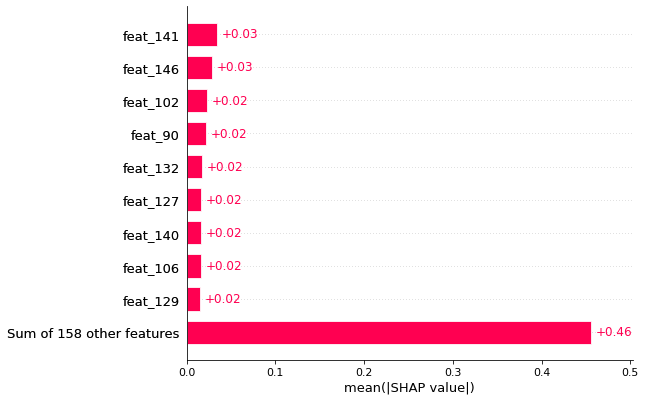

In [10]:
shap.plots.bar(shap_values)

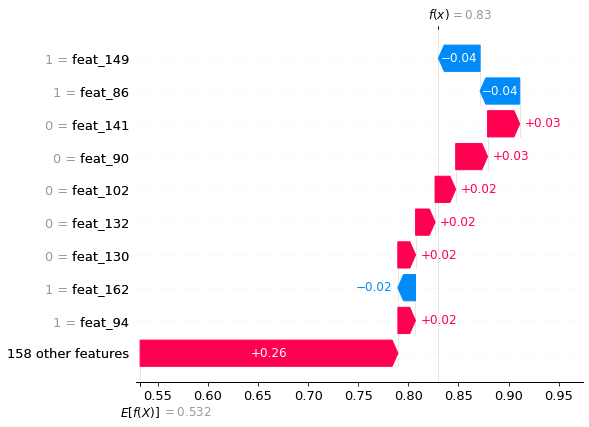

In [11]:
shap.plots.waterfall(shap_values[2400])

In [31]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

feat = 90
mol_number = 2400

smi = dataset.mols[mol_number]
mol = Chem.MolFromSmiles(smi)
print('Molecule number %d with smiles: %s' %(mol_number, smi))
print('Molecule number %d fingerprint: %s' %(mol_number, X.values[mol_number]))
print('Bit number %d: %d' %(feat, X.values[mol_number][feat-1]))
print('Molecule number %d prediction: %s' % (mol_number, str(model.predict_proba(X)[mol_number])))
print('Molecule number %d real value: %s' % (mol_number, dataset.y[mol_number]))

smart = smartsPatts[feat][0]
patt = Chem.MolFromSmarts(smart)
print('Pattern: ', smart)

print(mol.HasSubstructMatch(patt))

Molecule 2400 smiles: CN(C)c1ccc(cc1)C(=O)c1ccccc1C(O)=O
Molecule 2400 fingerprint: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
Bit number 90: 0
Molecule 2400 prediction: [0.17 0.83]
Molecule 2400 real value: 1
Pattern:  [$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[CH2;R]1)]
False


()


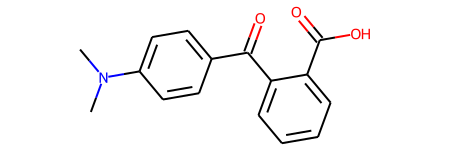

In [33]:
hit_at = mol.GetSubstructMatch(patt)
print(hit_at)

hit_bond = []
for bond in patt.GetBonds():
    id1 = hit_at[bond.GetBeginAtomIdx()]
    aid2 = hit_at[bond.GetEndAtomIdx()]
    hit_bond.append(mol.GetBondBetweenAtoms(id1, aid2).GetIdx())

d = rdMolDraw2D.MolDraw2DCairo(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=list(hit_at), highlightBonds=hit_bond)
mol

In [35]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[2400])

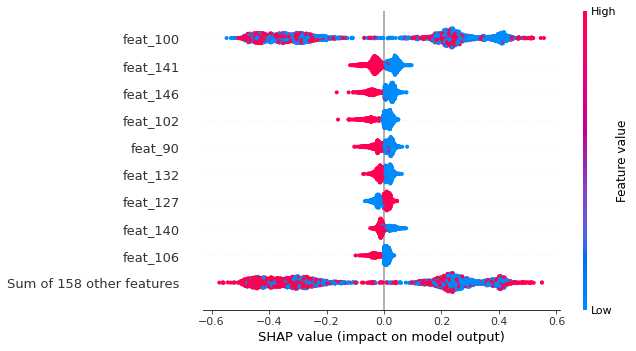

In [36]:
shap.plots.beeswarm(shap_values)

In [16]:
#pip install xgboost

In [39]:
# build a clustering of the features based on shared information about y
clustering = shap.utils.hclust(X, dataset.y)

# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(X, clustering=clustering)

# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(model.predict_proba, masker)
shap_values2 = explainer(X)

# get just the explanations for the positive class
shap_values2 = shap_values2[...,1]

No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 3 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 5 (this is typically caused by constant or near-constant features)! Cluster distan

 93%|█████████▎| 156/167 [03:37<00:13,  1.22s/it]No/low signal found from feature 155 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 156 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 157 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
100%|██████████| 167/167 [03:47<00:00,  1.15s/it]No/low signal found from feature 166 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
168it [03:47,  1.52s/it]                         
Permutation explainer: 2407it [35:42,  1.12it/s]                          


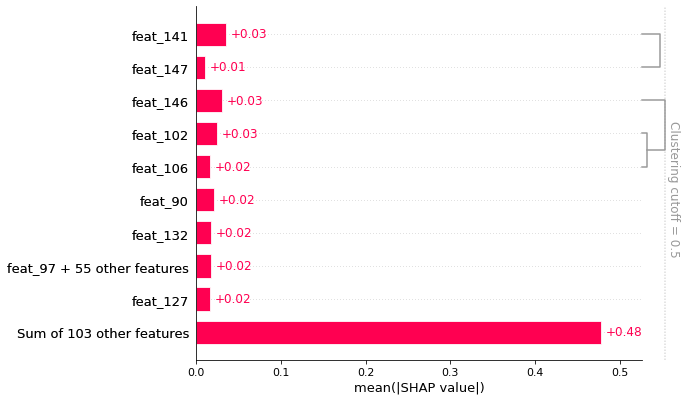

In [40]:
shap.plots.bar(shap_values2)

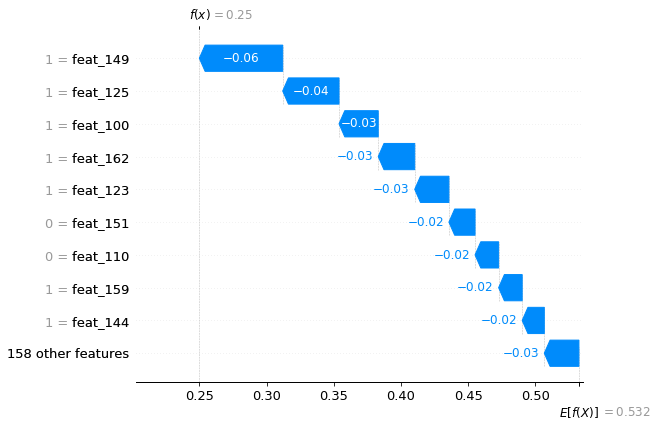

In [41]:
shap.plots.waterfall(shap_values2[0])